In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

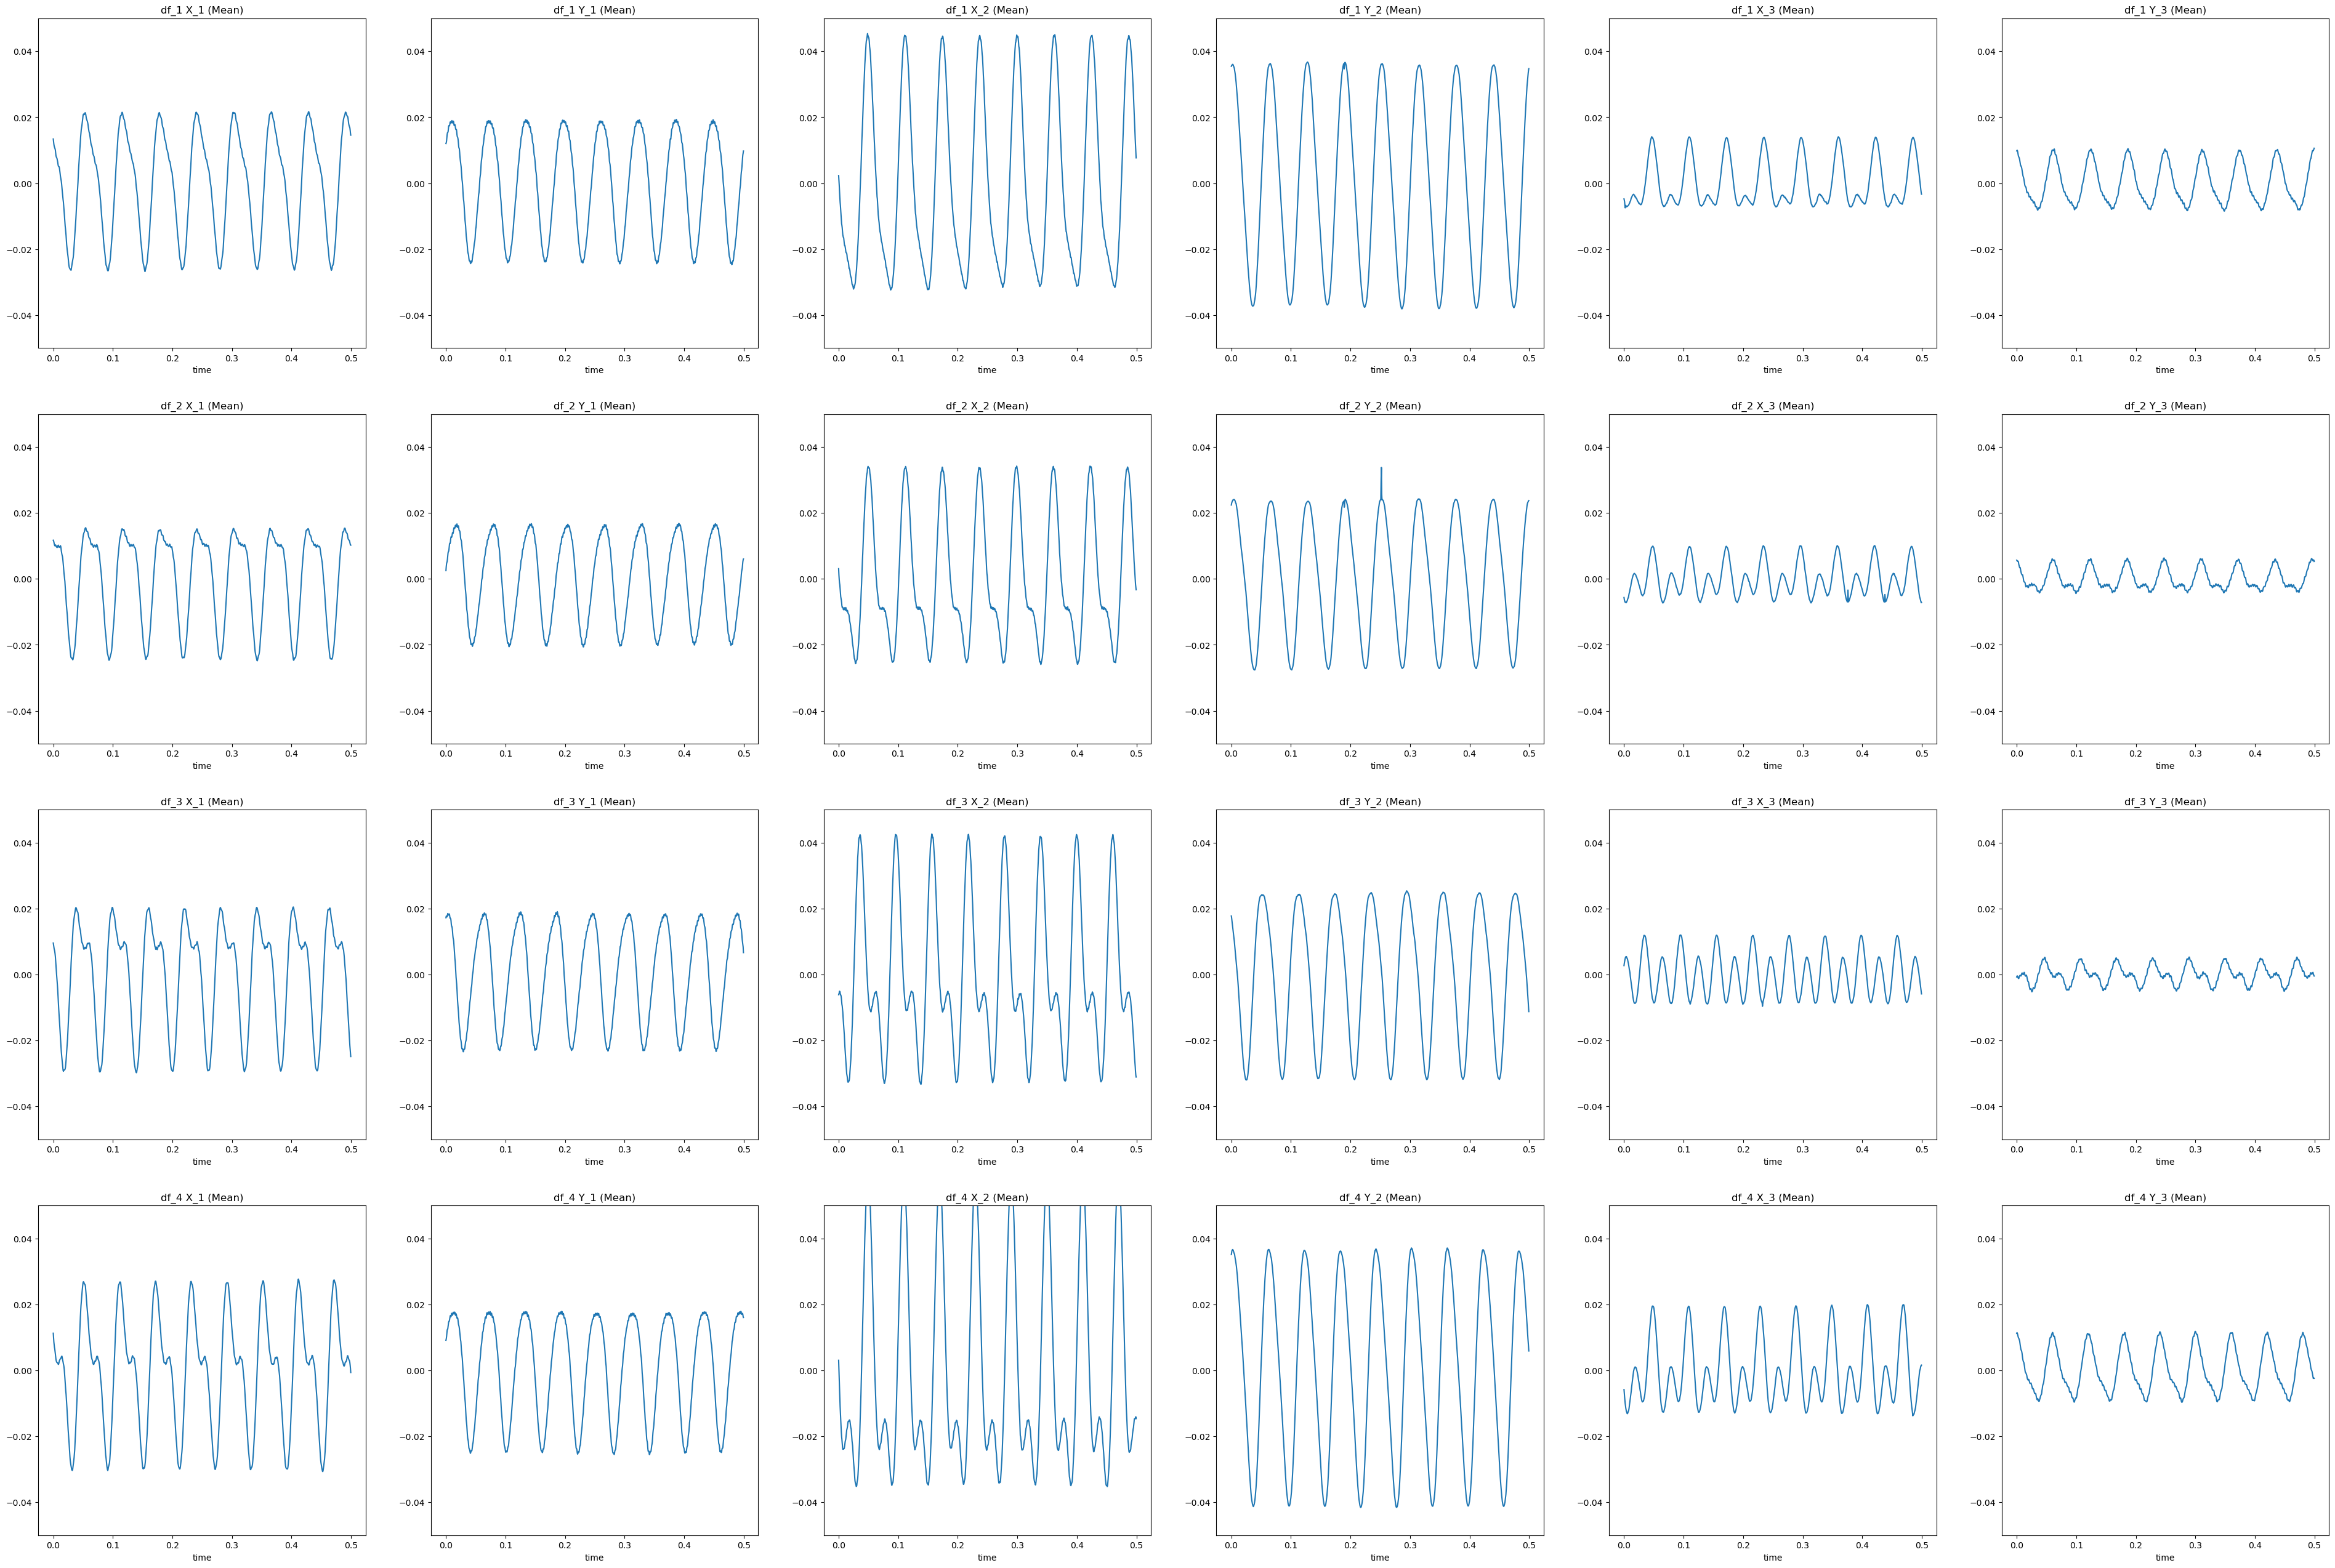

In [6]:
def plot_x_and_y(dfs):
    fig, axis = plt.subplots(len(dfs),6, figsize=(8*6,8*len(dfs)))
    columns = np.array([
    ['X_1 (Mean)','Y_1 (Mean)', 'X_2 (Mean)', 'Y_2 (Mean)' , 'X_3 (Mean)', 'Y_3 (Mean)'],
    ])

    for i,df in enumerate(dfs):
        
        for j in range(6):
            # axis[i, j].plot(df['X_Value'][:500],df[columns[i,j]][:500])
            axis[ i,j].plot(df['X_Value'][:1000].to_list(), df[columns[0,j]][:1000].to_list())
            axis[i,j].set_xlabel('time')
            axis[i,j].set_title(f"df_{i+1} {columns[0,j]}")
            axis[i,j].set_ylim([-0.05, 0.05])


df0 =  pd.read_csv("/home/ayon/Desktop/Digital Twin data/new_data/Train/no_screw/test01_001_16hz_ns.csv")
df1 = pd.read_csv('/home/ayon/Desktop/Digital Twin data/new_data/Train/with_screw/screw_1/test01_16,5hz_001.csv')

df2 = pd.read_csv('/home/ayon/Desktop/Digital Twin data/new_data/Train/with_screw/screw_2/test01_16,5hz_001.csv')

df3 = pd.read_csv('/home/ayon/Desktop/Digital Twin data/new_data/Train/with_screw/screw_3/test01_16,5hz_001.csv')


dfs = [df0, df1, df2, df3]

plot_x_and_y(dfs) 


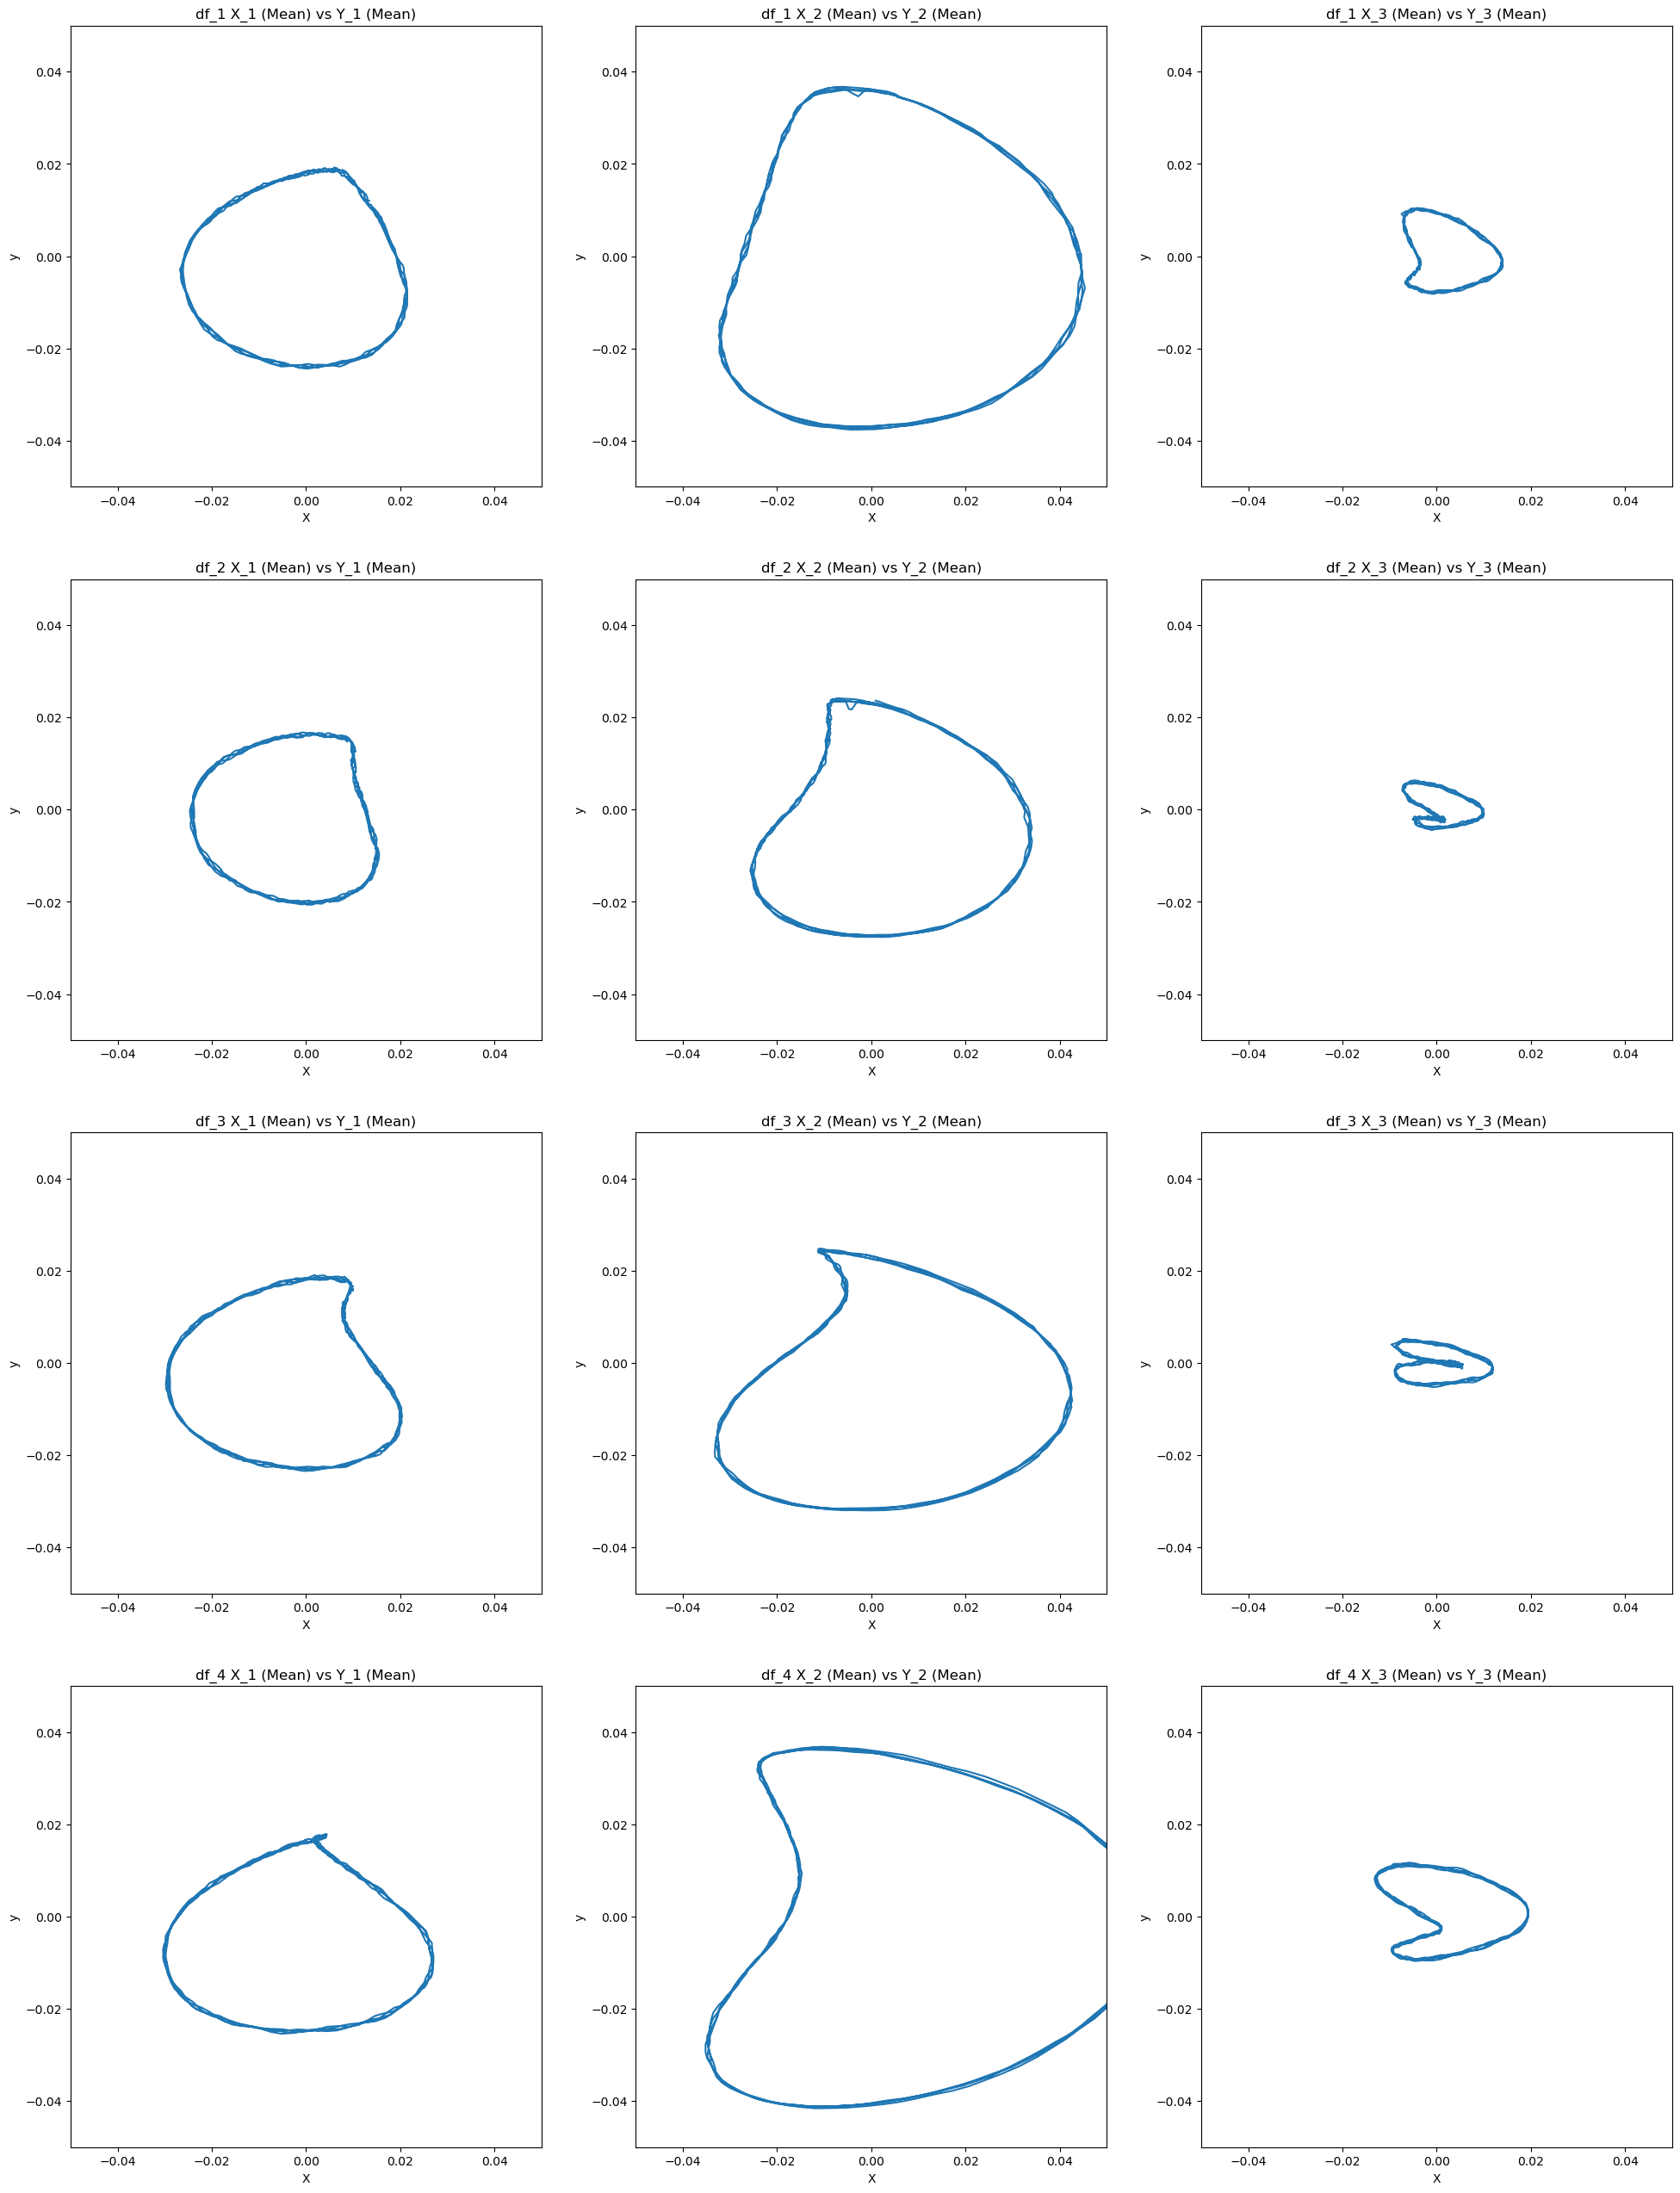

In [7]:
def xy_plot(dfs):
    fig, axis = plt.subplots(len(dfs),3, figsize=(8*3,8*len(dfs)))
    columns = np.array([
    ['X_1 (Mean)', 'X_2 (Mean)', 'X_3 (Mean)'], 
    ['Y_1 (Mean)', 'Y_2 (Mean)', 'Y_3 (Mean)'],
    ])

    for i,df in enumerate(dfs):
        for j in range(3):
            axis[i,j].plot(df[columns[0,j]][:500].to_list(), df[columns[1,j]][:500].to_list())
            axis[i,j].set_title(f'df_{i+1} {columns[0,j]} vs {columns[1,j]}')
            axis[i,j].set_ylim([-0.05,0.05])
            axis[i,j].set_xlim([-0.05,0.05])
            axis[i,j].set_xlabel('X')
            axis[i,j].set_ylabel('y')

xy_plot(dfs)
            

In [8]:
from dataset import DigitalTwinDataset

Dataset = DigitalTwinDataset('/home/ayon/Desktop/Digital Twin data/new_data/Train/', shuffle=True)



2

In [9]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust the batch size as needed
shuffle = True  # Set to True for random data shuffling

data_loader = DataLoader(Dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
print(len(data_loader))

77


In [ ]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * (sequence_length // 4), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Define model hyperparameters
input_channels = 6
sequence_length = 500
num_classes = 4

# Create an instance of the CNNClassifier model
model = CNNClassifier(input_channels, sequence_length, num_classes)
model= model.double()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Define the model (CNNClassifier) as defined in a previous response

# Define hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.001

# Create an instance of your model
model = CNNClassifier(input_channels=6, sequence_length=500, num_classes=4)
model = model.to(torch.float64)

# Define the loss function (cross-entropy) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for training and validation datasets
train_dataset = DigitalTwinDataset('/home/ayon/Desktop/Digital Twin data/new_data/Train/', shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data loader (if available)
# val_dataset = CustomClassificationDataset(val_data, val_labels)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in train_loader:
        inputs, labels = data['data'].reshape(-1,input_channels,sequence_length).to(torch.float64), data['label']

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Apply softmax to the model's output
        softmax_outputs = nn.functional.softmax(outputs, dim=1)

        # Compute cross-entropy loss
        target = F.one_hot(labels.to(torch.int64),num_classes=num_classes).to(torch.double)
        # print(labels.shape)
        # print(target.shape)

        # print(softmax_outputs.shape)
        loss = criterion(softmax_outputs, target)
        total_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy
        with torch.no_grad():
            _, predicted = torch.max(softmax_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}, Accuracy: {(100 * correct / total):.2f}%')

# Save the trained model if needed
# torch.save(model.state_dict(), 'your_model.pth')


Epoch [1/200], Loss: 1.3506228427140718, Accuracy: 37.05%
Epoch [2/200], Loss: 1.3309694903817368, Accuracy: 39.12%
Epoch [3/200], Loss: 1.2876073848001948, Accuracy: 45.47%
Epoch [4/200], Loss: 1.241011366529576, Accuracy: 51.40%
Epoch [5/200], Loss: 1.1916369578941557, Accuracy: 57.79%
Epoch [6/200], Loss: 1.1542516206326152, Accuracy: 59.98%
Epoch [7/200], Loss: 1.1241294820498235, Accuracy: 65.43%
Epoch [8/200], Loss: 1.0947576756062845, Accuracy: 70.15%
Epoch [9/200], Loss: 1.059229342941494, Accuracy: 74.01%
Epoch [10/200], Loss: 1.0359153053198444, Accuracy: 75.19%
Epoch [11/200], Loss: 1.0154960119239917, Accuracy: 76.13%
Epoch [12/200], Loss: 1.003623535491642, Accuracy: 76.74%
Epoch [13/200], Loss: 0.9930745109575381, Accuracy: 77.06%
Epoch [14/200], Loss: 0.986233192749595, Accuracy: 77.51%
Epoch [15/200], Loss: 0.9853912827275552, Accuracy: 77.51%
Epoch [16/200], Loss: 0.977382615425404, Accuracy: 77.96%
Epoch [17/200], Loss: 0.972445206665236, Accuracy: 78.61%
Epoch [18/20

In [ ]:
# import torch
# import torch.nn as nn

# class DeeperConvAutoencoder(nn.Module):
#     def __init__(self, input_channels, sequence_length, hidden_channels):
#         super(DeeperConvAutoencoder, self).__init__()

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#             nn.Conv1d(hidden_channels, hidden_channels // 2, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#         )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(hidden_channels // 2, hidden_channels, kernel_size=3, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose1d(hidden_channels, input_channels, kernel_size=3, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# # Define hyperparameters
# input_channels = 6  # Number of input channels
# sequence_length = 500  # Length of the time series data
# hidden_channels = 16  # Number of channels in the bottleneck layer

# # Create an instance of the DeeperConvAutoencoder model
# autoencoder = DeeperConvAutoencoder(input_channels, sequence_length, hidden_channels)
# autoencoder.to(torch.double)

DeeperConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Sigmoid()
  )
)

CUDA (GPU) is not available. Using CPU.


In [10]:
import torch
import torch.nn as nn

class DeeperConvAutoencoder(nn.Module):
    def __init__(self, input_channels, sequence_length, hidden_channels):
        super(DeeperConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(hidden_channels, hidden_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_channels // 2, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(hidden_channels, input_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        # Adjust the output size to match the input size
        output_size = x.size(2)  # Get the current sequence length
        if output_size < sequence_length:
            # Upsample the data to match the original sequence length
            upsample_factor = sequence_length // output_size
            x = nn.functional.interpolate(x, scale_factor=upsample_factor, mode='linear', align_corners=False)

        return x

# Define hyperparameters
input_channels = 6  # Number of input channels
sequence_length = 500  # Length of the time series data
hidden_channels = 16  # Number of channels in the bottleneck layer

# Create an instance of the DeeperConvAutoencoder model
autoencoder = DeeperConvAutoencoder(input_channels, sequence_length, hidden_channels)
autoencoder = autoencoder.to(torch.float64)

In [11]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA (GPU) is available.")
else:
    device = torch.device("cpu")
    print("CUDA (GPU) is not available. Using CPU.")


import dataset

# Create data loaders for training and validation datasets
Trainset = dataset.AutoEncoderDataset('/home/ayon/Desktop/Digital Twin data/new_data/AutoEncoder_data/Train/', device=device)


CUDA (GPU) is not available. Using CPU.


Epoch [1/1000], Loss: 0.26949106767192693
Epoch [2/1000], Loss: 0.26914621147676027
Epoch [3/1000], Loss: 0.26880109401252594
Epoch [4/1000], Loss: 0.268452053726555
Epoch [5/1000], Loss: 0.2681076222719389
Epoch [6/1000], Loss: 0.2677619687576617
Epoch [7/1000], Loss: 0.26741359989574837
Epoch [8/1000], Loss: 0.26706145459821107
Epoch [9/1000], Loss: 0.26670225053495467
Epoch [10/1000], Loss: 0.2663137977201214
Epoch [11/1000], Loss: 0.2659156976425386
Epoch [12/1000], Loss: 0.2655031739025132
Epoch [13/1000], Loss: 0.2650497029735089
Epoch [14/1000], Loss: 0.26457806334529504
Epoch [15/1000], Loss: 0.26411515635276966
Epoch [16/1000], Loss: 0.26365611093760516
Epoch [17/1000], Loss: 0.26320454313173924
Epoch [18/1000], Loss: 0.26275366166576936
Epoch [19/1000], Loss: 0.2623059173035606
Epoch [20/1000], Loss: 0.26185867969651927
Epoch [21/1000], Loss: 0.2614077953294487
Epoch [22/1000], Loss: 0.26095801353556064
Epoch [23/1000], Loss: 0.2605057793955462
Epoch [24/1000], Loss: 0.260048

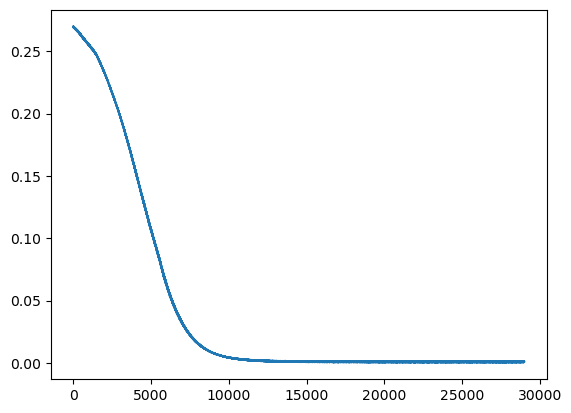

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Define the model (CNNClassifier) as defined in a previous response

# Define hyperparameters
batch_size = 32
num_epochs = 1000
learning_rate = 0.00001

# Define hyperparameters
input_channels = 6  # Number of input channels
sequence_length = 500  # Length of the time series data
hidden_channels = 16  # Number of channels in the bottleneck layer


# Create an instance of your model
model = DeeperConvAutoencoder(input_channels, sequence_length, hidden_channels)
model = model.to(torch.float64)

# Define the loss function (cross-entropy) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(Trainset, batch_size=batch_size, shuffle=True)

# Validation data loader (if available)
# val_dataset = CustomClassificationDataset(val_data, val_labels)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
loss_list = []
total_loss_list = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in train_loader:
        inputs = data['data'].reshape(-1,input_channels,sequence_length).to(torch.float64)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, inputs)
        loss_list.append(loss.item())
        total_loss += loss.item()
        

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy
        # with torch.no_grad():
        #     _, predicted = torch.max(softmax_outputs, 1)
        #     total += labels.size(0)
        #     correct += (predicted == labels).sum().item()

    # Print statistics
    total_loss_list.append(total_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

# Save the trained model if needed
torch.save(model.state_dict(), 'auto_encoder.pth')
plt.plot(loss_list)


In [32]:
import dataset
test_set = dataset.DigitalTwinDataset('/home/ayon/Desktop/Digital Twin data/new_data/AutoEncoder_data/Test/', device=device, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

model.eval()
mse = nn.MSELoss()
for data in test_loader:
    inputs,labels = data['data'].reshape(-1,input_channels,sequence_length).to(torch.float64), data['label']

    if labels.sum().item()==3:
        outputs = model(inputs)
        loss = mse(outputs, inputs)
        print(loss.item())
        break
    # break
print(inputs.shape)
print(labels)



0.0004615179870455543
torch.Size([1, 6, 500])
tensor([3.], dtype=torch.float64)


In [61]:
import torch
import torch.nn as nn

class SeqToSeqLSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length):
        super(SeqToSeqLSTMAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Decoder
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=input_size, num_layers=num_layers, batch_first=True)
        self.sequence_length = sequence_length

    def forward(self, x):
        # Encoding
        encoder_out, (hidden_state, cell_state) = self.encoder(x)
        
        # Decoding
        decoder_out, _ = self.decoder(encoder_out)
        
        return decoder_out

# Define hyperparameters
input_size = 6  # Number of input features
hidden_size = 8  # Number of hidden units
num_layers = 2  # Number of LSTM layers
sequence_length = 500  # Length of the input sequence

# Create an instance of the SeqToSeqLSTMAutoencoder model
autoencoder = SeqToSeqLSTMAutoencoder(input_size, hidden_size, num_layers, sequence_length)

autoencoder = autoencoder.to(torch.double)

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Define the model (CNNClassifier) as defined in a previous response

# Define hyperparameters
batch_size = 32
num_epochs = 300
learning_rate = 0.001

# Define hyperparameters
input_size = 6  # Number of input features
hidden_size = 8  # Number of hidden units
num_layers = 1  # Number of LSTM layers
sequence_length = 500  # Length of the time series data

# Create an instance of the LSTMAutoencoder model
model = LSTMAutoencoder(input_size, hidden_size, num_layers, sequence_length)
model = model.to(torch.float64)

# Define the loss function (cross-entropy) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(Trainset, batch_size=batch_size, shuffle=True)


# Training loop
def train(model=model, criterion=criterion, train_loader=train_loader, optimizer=optimizer, save_name='autoencoder_lstm',num_epochs=num_epochs):
    loss_list = []
    total_loss_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data in train_loader:
            inputs = data['data'].reshape(-1,500,6).to(torch.float64)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            loss = criterion(outputs, inputs)
            loss_list.append(loss.item())
            total_loss += loss.item()
            

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Compute accuracy
            # with torch.no_grad():
            #     _, predicted = torch.max(softmax_outputs, 1)
            #     total += labels.size(0)
            #     correct += (predicted == labels).sum().item()

        # Print statistics
        total_loss_list.append(total_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

    # Save the trained model if needed
    torch.save(model.state_dict(), f'{save_name}.pth')
    plt.plot(loss_list)


train()

Epoch [1/300], Loss: 0.016847062839671835
Epoch [2/300], Loss: 0.007220725225360905
Epoch [3/300], Loss: 0.002259769682323475
Epoch [4/300], Loss: 0.0007865575951160322
Epoch [5/300], Loss: 0.0006826477404139113
Epoch [6/300], Loss: 0.0005668528274785556
Epoch [7/300], Loss: 0.0004226927815643286
Epoch [8/300], Loss: 0.00035943595371838103
Epoch [9/300], Loss: 0.000322263112925402
Epoch [10/300], Loss: 0.00029300486932359404
Epoch [11/300], Loss: 0.0002632820819413652
Epoch [12/300], Loss: 0.00022732644469487
Epoch [13/300], Loss: 0.00018051668245892334
Epoch [14/300], Loss: 0.00013859068023587285
Epoch [15/300], Loss: 0.00011607052977444775
Epoch [16/300], Loss: 0.00010041949919148481
Epoch [17/300], Loss: 8.839787091420873e-05
Epoch [18/300], Loss: 7.86006521521006e-05
Epoch [19/300], Loss: 7.083985916650337e-05
Epoch [20/300], Loss: 6.489642640735316e-05
Epoch [21/300], Loss: 5.9986766500596594e-05
Epoch [22/300], Loss: 5.620613428406625e-05
Epoch [23/300], Loss: 5.314212599766393e-

In [79]:
import dataset
test_set = dataset.DigitalTwinDataset('/home/ayon/Desktop/Digital Twin data/new_data/AutoEncoder_data/Test/', device=device, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

model.eval()
mse = nn.MSELoss()
for data in test_loader:
    inputs,labels = data['data'].reshape(-1,500,6).to(torch.float64), data['label']

    if labels.sum().item()==3:
        outputs = model(inputs)
        loss = mse(outputs, inputs)
        print(loss.item())
        break
    # break
print(inputs.shape)
print(labels)


3.163766592077166e-05
torch.Size([1, 500, 6])
tensor([3.], dtype=torch.float64)
